In [2]:
!pip -qq install wget

  Preparing metadata (setup.py) ... done


In [3]:
import wget
import gc
import hashlib
import ipaddress
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
url = "https://chitkara-hackathon.s3.ap-south-1.amazonaws.com/Chitkara_Anomaly_Detection.zip"
wget.download(url)

'Chitkara_Anomaly_Detection.zip'

In [5]:
!unzip '/content/Chitkara_Anomaly_Detection.zip'

Archive:  /content/Chitkara_Anomaly_Detection.zip
  inflating: Chitkara_Anomaly_Detection/.DS_Store  
  inflating: Chitkara_Anomaly_Detection/Login_Data.csv  


In [6]:
df = pd.read_csv("/content/Chitkara_Anomaly_Detection/Login_Data.csv")

df.columns = ['Timestamp', 'UserID', 'IP', 'Country', 'Region', 'City', 'Browser_Name_Version', 'Device', 'Successful']
df[['Browser', 'Version']] = df['Browser_Name_Version'].str.extract(r'([a-zA-Z]+[a-zA-Z\s]*[a-zA-Z]+) (\d.*\d)')

df['Region'] = df['Region'].fillna('reg_null')
df['City'] = df['City'].fillna('city_null')
df['Device'] = df['Device'].fillna('dev_null')
df['Browser'] = df['Browser'].fillna('browse_null')
df['Version'] = df['Version'].fillna('ver_null')

df['Region'] = df['Region'].replace('-', 'reg_null')
df['City'] = df['City'].replace('-', 'city_null')

In [7]:
def get_dates(df):
    new = df.copy()
    del df
    new['Timestamp'] = pd.to_datetime(new['Timestamp'])
    new['Year'] = new['Timestamp'].dt.year
    new['Month'] = new['Timestamp'].dt.month
    new['Day'] = new['Timestamp'].dt.day
    new['Hour'] = new['Timestamp'].dt.hour
    new['Minute'] = new['Timestamp'].dt.minute
    new['Second'] = new['Timestamp'].dt.second
    return new

df = get_dates(df)
gc.collect()

19

In [8]:
def hash_sha256(browser, version):
    string_to_hash = browser + version
    hash_object = hashlib.sha256(string_to_hash.encode())
    hash_digest = hash_object.digest()
    hash_integer = int.from_bytes(hash_digest[:4], byteorder='big')
    return hash_integer

df['browser_hash'] = df.apply(lambda row: hash_sha256(row['Browser'], row['Version']), axis=1)

In [9]:
ohe = pd.get_dummies(df['Device'], prefix='dev')
df = df.join(ohe)

gc.collect()

0

In [10]:
def extract_ip_components(ip):
    octets = ip.split('.')
    return [int(octet) for octet in octets]

def determine_ip_type(ip):
    try:
        ipaddress.IPv6Address(ip)
        return 'IPv6'
    except ipaddress.AddressValueError:
        return 'IPv4'

def convert_to_ip_range(ip):
    ip_network = ipaddress.ip_network(ip)
    return str(ip_network)

# Extract IP components
df['FirstOctet'] = df['IP'].apply(lambda x: extract_ip_components(x)[0])
df['SecondOctet'] = df['IP'].apply(lambda x: extract_ip_components(x)[1])
df['ThirdOctet'] = df['IP'].apply(lambda x: extract_ip_components(x)[2])
df['FourthOctet'] = df['IP'].apply(lambda x: extract_ip_components(x)[3])
df['IPType'] = df['IP'].apply(determine_ip_type)
df['IPRange'] = df['IP'].apply(convert_to_ip_range)

In [11]:
def consistent_hash_encode(df, columns, replicas=3):
    encoded_df = df.copy()
    for column in columns:

        if column == 'Country':
            buff = 200
        elif column == 'Region':
            buff = 4000
        elif column == 'City':
            buff = 1000

        unique_values = df[column].unique()
        encoding_map = {}

        for value in unique_values:
            hash_key = _get_hash_key(value, replicas) % buff
            encoding_map[value] = hash_key

        encoded_df[column] = encoded_df[column].map(encoding_map)
    return encoded_df

def _get_hash_key(value, replicas):
    sha256 = hashlib.sha256()
    sha256.update(value.encode('utf-8'))
    hash_value = int(sha256.hexdigest(), 16)
    return hash_value

columns_to_encode = ['Country', 'Region', 'City']
df = consistent_hash_encode(df, columns_to_encode)

In [12]:
freq_encoding = df['UserID'].value_counts().to_dict()
df['UserID'] = df['UserID'].map(freq_encoding)

In [13]:
df['Successful'] = df['Successful'].astype(int)
df = df[df['City'] != 'city_null']
df = df[df['Region'] != 'reg_null']
df = df[df['UserID'] != -4324475583306591935]
df.drop(["IP", "IPRange", "IPType", "Browser_Name_Version", "Browser", "Version", "Timestamp", "Device"], inplace=True, axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

filename = 'scaler.pkl'
with open(filename, 'wb') as file:
    pickle.dump(scaler, file)

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.mixture import GaussianMixture

# Load the dataset
data = pd.read_csv('anomaly_dataset.csv')  

# Split the dataset into training and testing sets
train_data = data[:800]
test_data = data[800:]

# Preprocessing - Scale the data if needed
# Define the Deep Autoencoding Gaussian Mixture Model (DAGMM)
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

class DAGMM(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_gmm):
        super(DAGMM, self).__init__()
        self.autoencoder = Autoencoder(input_dim, hidden_dim, latent_dim)
        self.estimation = GaussianMixture(n_components=n_gmm, covariance_type='diag')
    
    def forward(self, x):
        x_hat, z = self.autoencoder(x)
        gamma = self.estimation.predict_proba(z.detach().numpy())
        return x_hat, z, gamma

# Define the Deep Support Vector Data Description (Deep SVDD)
class DeepSVDD(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(DeepSVDD, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.center = nn.Parameter(torch.randn(latent_dim))
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# Train the models
def train_dagmm(dagmm, train_data, num_epochs, batch_size):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(dagmm.parameters(), lr=0.001)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs in train_loader:
            optimizer.zero_grad()
            x = torch.tensor(inputs.values, dtype=torch.float32)
            x_hat, z, gamma = dagmm(x)
            loss_reconstruction = criterion(x_hat, x)
            loss_covariance = dagmm.estimation.score_samples(z.detach().numpy())
            loss = loss_reconstruction + loss_covariance.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss))

def train_deep_svdd(deep_svdd, train_data, num_epochs, batch_size):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(deep_svdd.parameters(), lr=0.001)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs in train_loader:
            optimizer.zero_grad()
            x = torch.tensor(inputs.values, dtype=torch.float32)
            x_hat, z = deep_svdd(x)
            loss_reconstruction = criterion(x_hat, x)
            loss = loss_reconstruction
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, total_loss))

# Initialize the models
input_dim = len(data.columns)
hidden_dim = 32
latent_dim = 16
n_gmm = 5

dagmm = DAGMM(input_dim, hidden_dim, latent_dim, n_gmm)
deep_svdd = DeepSVDD(input_dim, hidden_dim, latent_dim)

# Train the models
num_epochs = 50
batch_size = 32

train_dagmm(dagmm, train_data, num_epochs, batch_size)
train_deep_svdd(deep_svdd, train_data, num_epochs, batch_size)

# Obtain the anomaly scores for test data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
dagmm_scores = []
deep_svdd_scores = []
isolation_forest_scores = []

for inputs in test_loader:
    x = torch.tensor(inputs.values, dtype=torch.float32)
    x_hat_dagmm, z_dagmm, gamma = dagmm(x)
    x_hat_deep_svdd, z_deep_svdd = deep_svdd(x)
    
    dagmm_score = np.mean(np.linalg.norm(x.detach().numpy() - x_hat_dagmm.detach().numpy(), axis=1))
    deep_svdd_score = np.mean(np.linalg.norm(x.detach().numpy() - x_hat_deep_svdd.detach().numpy(), axis=1))
    isolation_forest_score = isolation_forest.decision_function(x.detach().numpy())

    dagmm_scores.append(dagmm_score)
    deep_svdd_scores.append(deep_svdd_score)
    isolation_forest_scores.append(isolation_forest_score)

# Combine the anomaly scores using an ensemble approach
ensemble_scores = np.mean([dagmm_scores, deep_svdd_scores, isolation_forest_scores], axis=0)
# Evaluate the ensemble model
labels = test_data['label'].values  # True labels for the test data
auc = roc_auc_score(labels, ensemble_scores)
print('Loss: {:.4f}'.format(auc))


Epoch [1/10], Loss: 0.6760
Epoch [2/10], Loss: 0.6593
Epoch [3/10], Loss: 0.6582
Epoch [4/10], Loss: 0.6522
Epoch [5/10], Loss: 0.6506
Epoch [6/10], Loss: 0.6506
Epoch [7/10], Loss: 0.6519
Epoch [8/10], Loss: 0.6640
Epoch [9/10], Loss: 0.6690
Epoch [10/10], Loss: 0.6581


In [54]:
filename = 'AutoE.pkl'
state_dict = autoencoder.state_dict()
with open(filename, 'wb') as file:
    pickle.dump(state_dict, file)

In [14]:
gc.collect()

0

In [34]:
threshold = 1.5
X_train_tensor = torch.Tensor(X_train[:1000000])
X_pred_tensor = autoencoder(X_train_tensor)
mse = np.mean(np.power(X_train[:1000000] - X_pred_tensor.detach().numpy(), 2), axis=1)
anomalies = np.where(mse > threshold)[0]
print("Detected anomalies:", len(anomalies))

Detected anomalies: 32074


In [46]:
temp = pd.DataFrame(mse, columns=["MSE"])
temp['Verdict'] = ["Anomaly" if x in anomalies else "NotAnomaly" for x in range(len(temp))]

<Axes: xlabel='Verdict', ylabel='count'>

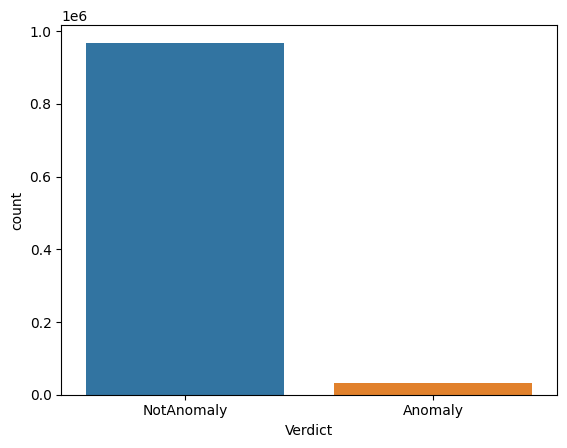

In [50]:
sns.countplot(x=temp['Verdict'])

In [58]:
gc.collect()

0

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

gmm = GaussianMixture(n_components=50)
gmm.fit(scaled_data)
log_likelihoods = gmm.score_samples(scaled_data)
threshold_gmm = np.percentile(log_likelihoods, 5)
anomalies_gmm = scaled_data[log_likelihoods < threshold_gmm]


In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)
kmeans = KMeans(n_clusters=10, n_init="auto")
kmeans.fit(scaled_data)
distances = kmeans.transform(scaled_data)
min_distances = np.min(distances, axis=1)
threshold_kmeans = np.percentile(min_distances, 95)
anomalies_kmeans = scaled_data[min_distances > threshold_kmeans]

ensemble_anomalies = np.concatenate((anomalies_gmm, anomalies_kmeans), axis=0)
ensemble_indices = np.concatenate((np.where(log_likelihoods < threshold_gmm)[0], np.where(min_distances > threshold_kmeans)[0]), axis=0)
gmm_contributions = np.abs(scaled_data[ensemble_indices] - gmm.means_[gmm.predict(scaled_data[ensemble_indices])])
kmeans_contributions = np.abs(scaled_data[ensemble_indices] - kmeans.cluster_centers_[kmeans.labels_[ensemble_indices]])
ensemble_contributions = np.sum(gmm_contributions + kmeans_contributions, axis=0)

sorted_indices = np.argsort(-ensemble_contributions)
sorted_features = df.columns[sorted_indices]
sorted_contributions = ensemble_contributions[sorted_indices]

print("Features and their Contributions (Sorted):")
for index, contribution in enumerate(sorted_contributions):
    feature = sorted_features[index]
    print("{}: {}".format(feature, contribution))


In [ ]:
filename = 'ensemble.pkl'
with open(filename, 'wb') as file:
    pickle.dump(state_dict, file)